### Libraries

In [241]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

### Utils

In [2]:
def describe_graph(name,data,transpose=False,showfliers=True):
    """ Generate boxplot with the combination of Variable and Variable_Duration
    Args:
        name (str): Variable that has a Variable_Duration columns
        data (pandas.DataFrame): Information to be use in the boxplot viz
        transpose (boolean) = False: swift varioble x for y
        showfliers (booolean) = True: Option to show or disable the outliers in Boxplot viz
    """
    x_name = name
    y_name = "{}_Duration".format(name)
    print("Unique values: {}".format(len(dataframe[x_name].unique())))
    if transpose:
        sns.boxplot(y=x_name,x=y_name,data=data,showfliers=showfliers)
    else:
        sns.boxplot(x=x_name,y=y_name,data=data,showfliers=showfliers)

def bar_correlation(corr_matrix,feature,threshold):
    """ Function to viz one line of the correlation matrix with a bar plot
        Args:
            corr_matrix (np.array): correlation matrix of the features , can include the target variable
            feature (str): name of the feature to calculate the graph
            threshold (int): limit what variables to show if the correlation is not more than the given value
    """
    plt.figure(figsize=(15,5))
    z = corr_matrix.drop(feature,axis=0)[feature].sort_values(ascending=False)
    z = z[abs(z.values) > threshold]
    sns.barplot(x=z.index, y=z.values)
    plt.xticks(rotation=90)
    plt.show()

def histogram_boxplot(feature, figsize=(15, 5), bins=None):
    """ Boxplot and histogram combined
        Args:
            feature (array): feature vector
            figsize (tuple[int,int]): size of fig 
            bins (int): number of bins
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        feature, kde=False, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

### Objective

- Classify customer into Buyers (Revenue = True) or Explorers (Revenue = False)
- Find relevant groups that can be use for targeting (Cluster Customers)
- Build a process for Missing Information for Customers

### Data Understanding & EDA

[Online Shoppers Purchasing Intention Dataset](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset).

- The dataset consists of 10 numerical and 8 categorical variables.

In [3]:
dataframe = pd.read_csv("../data/online_shoppers_intention.csv.gz")

In [4]:
print(dataframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

The categorical variables are represent in numeric value. 

- Variable `Revenue` is the target label. This binary variable is imbalanced, specifically 84.5% of user journeys did NOT result in a purchase; in other words `Revenue` is False.

Number of purchase by online customer 15.47%


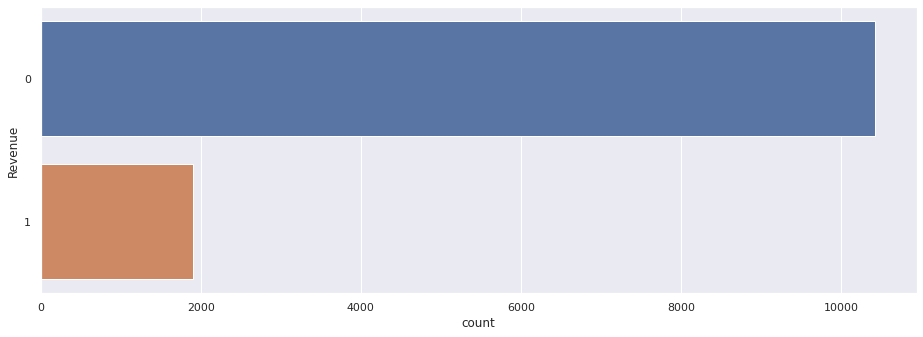

In [6]:
revenue = dataframe[["Revenue"]].astype(int)
sale_prob = revenue.mean()[0]
print("Number of purchase by online customer {:.2f}%".format(sale_prob*100))
sns.set(rc={'figure.figsize':(15.7,5.27)})
sns.countplot(y="Revenue",data=revenue)
plt.show()

For the variable Revenue it will be applied methos of oversmpling and bucketing (Cluster the data and then applied different models)


- `Administrative`, `Administrative Duration`, `Informational`, `Informational Duration`, `Product Related`, and `Product Related Duration` represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated when a user takes an action, e.g, moving from one page to another.

Unique values: 27


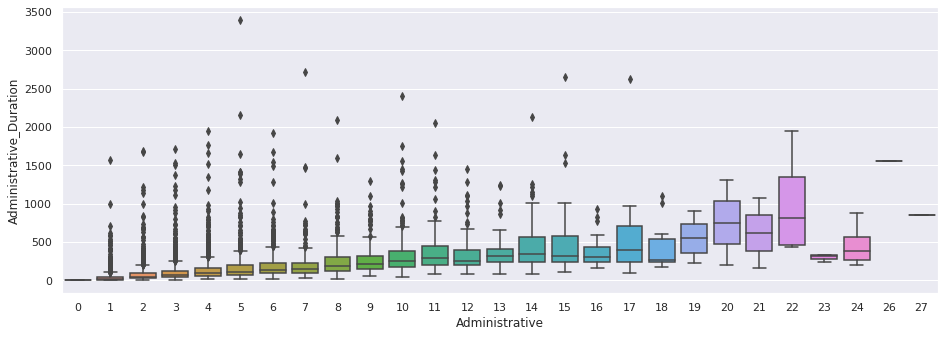

In [9]:
describe_graph("Administrative",dataframe)

Unique values: 17


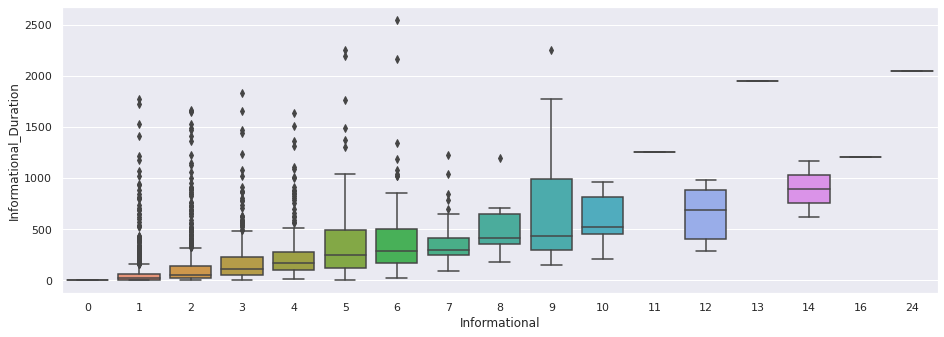

In [10]:
describe_graph("Informational",dataframe)

Unique values: 311


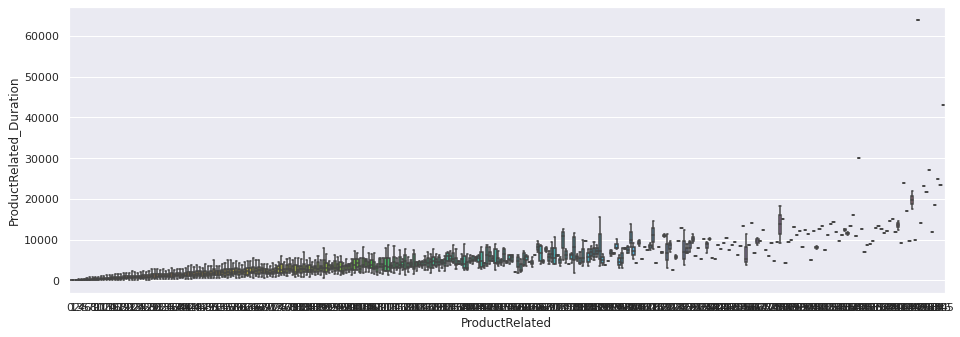

In [11]:
describe_graph("ProductRelated",dataframe,showfliers=False)

In [12]:
corr_matrix = dataframe[[
    "Administrative","Administrative_Duration"
    ,"Informational","Informational_Duration"
    ,"ProductRelated","ProductRelated_Duration"]
].corr()

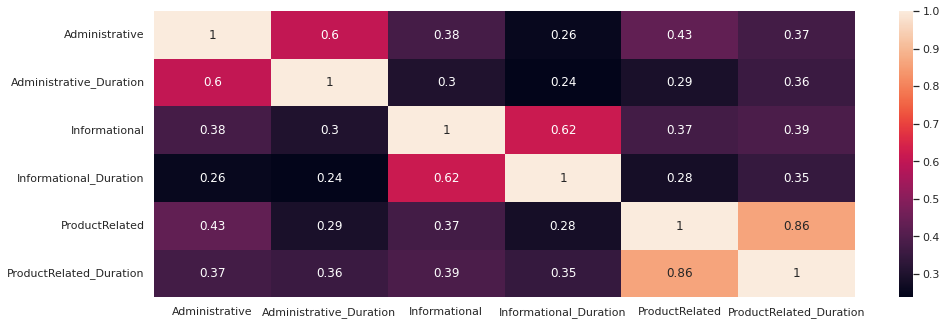

In [13]:
sns.heatmap(corr_matrix,annot=True)
plt.show()

These variables show that exists a linear relationship between the the number of page visit and the duration of the same. It will be evaluate if the features can be dropout of the set of features or combine it due to the colinearity that can inject to the models (And create weights that are bias). It can be applied PCA using this features to get a vector of behavior between the user and the product.

In [8]:
pca = PCA(n_components=3)

In [12]:
behavior = dataframe[["Administrative","Administrative_Duration","Informational","Informational_Duration","ProductRelated","ProductRelated_Duration"]]
behavior_scaled = StandardScaler().fit_transform(behavior)
behavior_reduced = pca.fit_transform(behavior_scaled)

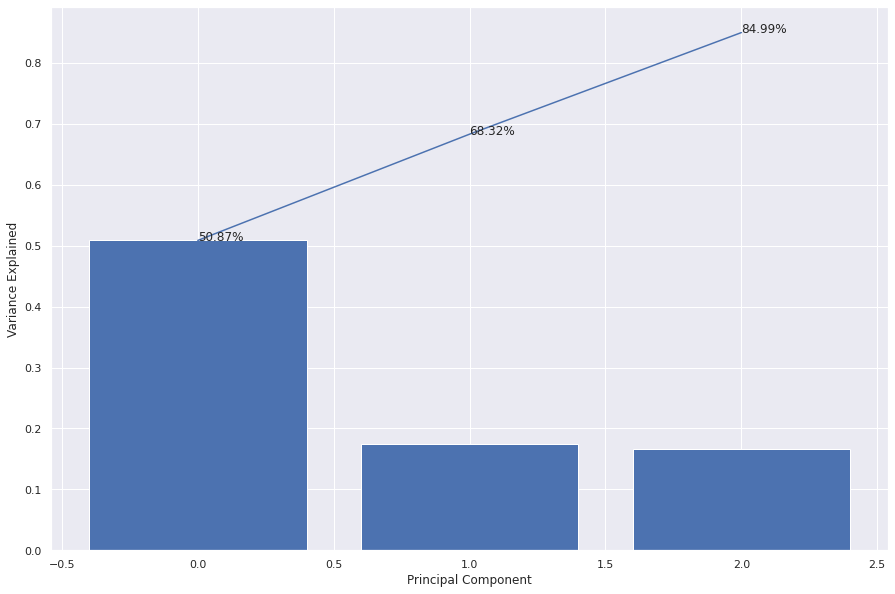

In [18]:
# Grap the variance explained by each of the principal components pca model and the cumulative variance explained
plt.figure(figsize=(15,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
# annotate the graph with the percentage of variance explained by each of the principal components
for i,j in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    plt.text(i,j,str(round(j*100,2))+"%")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.bar(range(3),pca.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.show()

Features `Bounce Rate`, `Exit Rate` and `Page Value` represent  metrics measured by Google Analytics for each page in the e-commerce site. 

- The value of `Bounce Rate` for a web page refers to the percentage of visitors who enter the site from that page and then leave (i.e., bounce) without triggering any other requests to the analytics server during that session. 

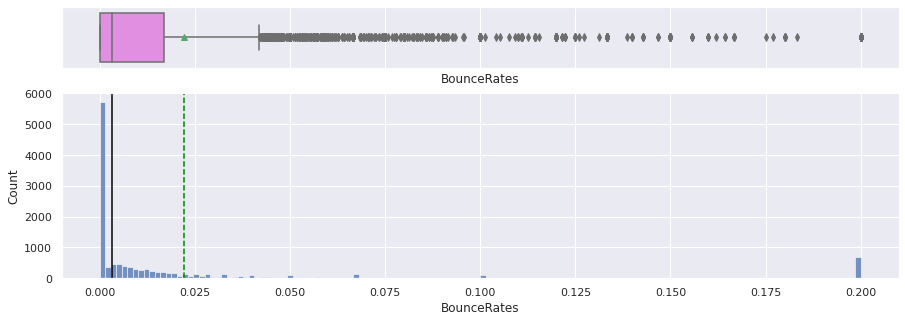

In [14]:
histogram_boxplot(dataframe["BounceRates"])

- The value of `Exit Rate` for a specific web page is calculated as for all page views to the page and it represents the percentage that the page was seen in the last session. 

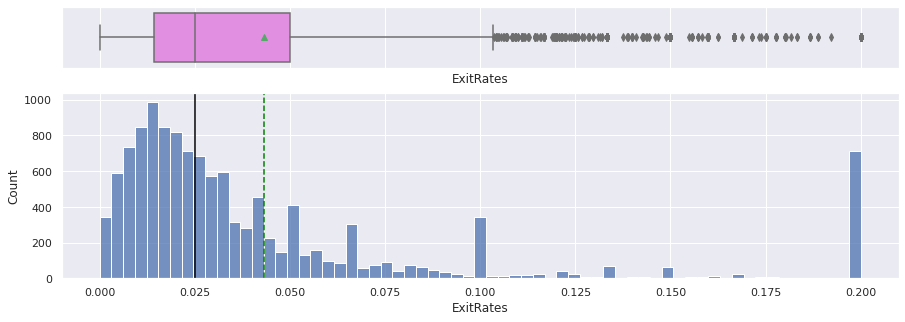

In [15]:
histogram_boxplot(dataframe["ExitRates"])

- Feature `Page Value` represents the average value for a web page that a user visited before completing an e-commerce transaction. 

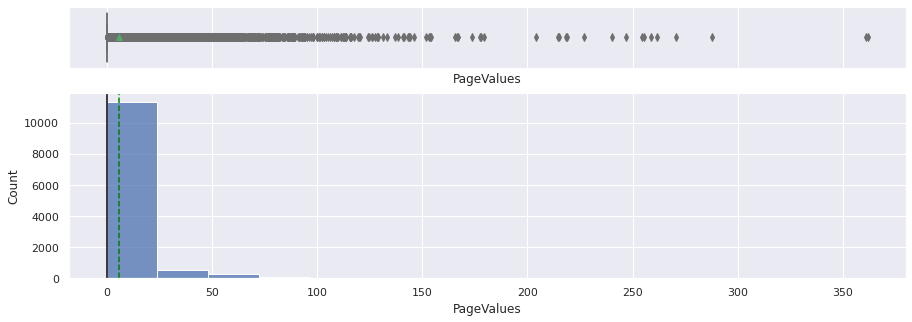

In [16]:
histogram_boxplot(dataframe["PageValues"])

For the numerical values of this section we will have to scale with thecniques that can address outliers given that it shows long tails and skew to zero

- Feature `Special Day` indicates the closeness of the site visiting time to a specific special day (e.g., Mother’s Day or Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. 

In [17]:
pd.DataFrame(dataframe.value_counts("Month")).T

Month,May,Nov,Mar,Dec,Oct,Sep,Aug,Jul,June,Feb
0,3364,2998,1907,1727,549,448,433,432,288,184


In [18]:
dataframe.groupby("Month").agg({"SpecialDay":"mean"}).T

Month,Aug,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep
SpecialDay,0.0,0.0,0.233696,0.0,0.0,0.0,0.212366,0.0,0.0,0.0


Feb has 42.93% of Special Day value


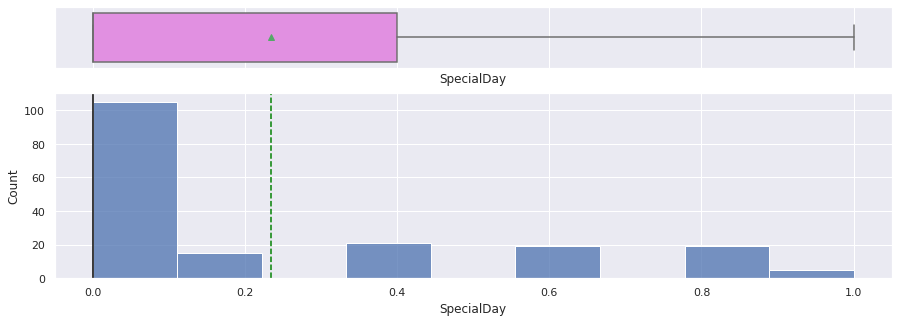

May has 34.84% of Special Day value


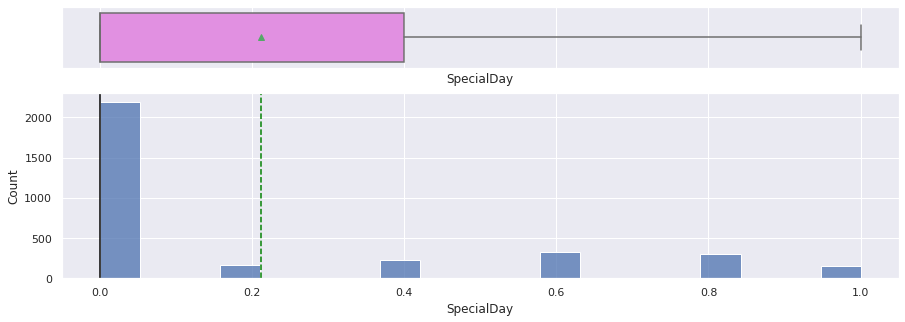

All other months do not have value


In [19]:
for month, df in dataframe.groupby("Month"):
    mean_special_day = np.mean(df["SpecialDay"]>0)
    if mean_special_day>0:
        print("{} has {}% of Special Day value".format(month,np.round(mean_special_day*100,2)))
        histogram_boxplot(df["SpecialDay"])
        plt.show()
print("All other months do not have value")

The special day can be use to generate a dummy variable indicating if the month has a Special date in it. given that just twom months has value for this feature. and it can be a combination of a Month with special day, and the value of the special date. 



- The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a boolean value indicating whether the date of the visit is weekend, and month of the year.

In [20]:
pd.DataFrame(dataframe.value_counts("OperatingSystems")).T

OperatingSystems,2,1,3,4,8,6,7,5
0,6601,2585,2555,478,79,19,7,6


In [21]:
pd.DataFrame(dataframe.value_counts("Browser")).T

Browser,2,1,4,5,6,10,8,3,13,7,12,11,9
0,7961,2462,736,467,174,163,135,105,61,49,10,6,1


In [22]:
pd.DataFrame(dataframe.value_counts("Region")).T

Region,1,3,4,2,6,7,9,8,5
0,4780,2403,1182,1136,805,761,511,434,318


In [23]:
pd.DataFrame(dataframe.value_counts("TrafficType")).T

TrafficType,2,1,3,4,13,10,6,8,5,11,20,9,7,15,19,14,18,16,12,17
0,3913,2451,2052,1069,738,450,444,343,260,247,198,42,40,38,17,13,10,3,1,1


ALL the operation / System with me process as categorical variables

In [24]:
pd.DataFrame(dataframe.value_counts("Weekend")).T

Weekend,False,True
0,9462,2868


In [25]:
pd.DataFrame(dataframe.value_counts("VisitorType")).T

VisitorType,Returning_Visitor,New_Visitor,Other
0,10551,1694,85


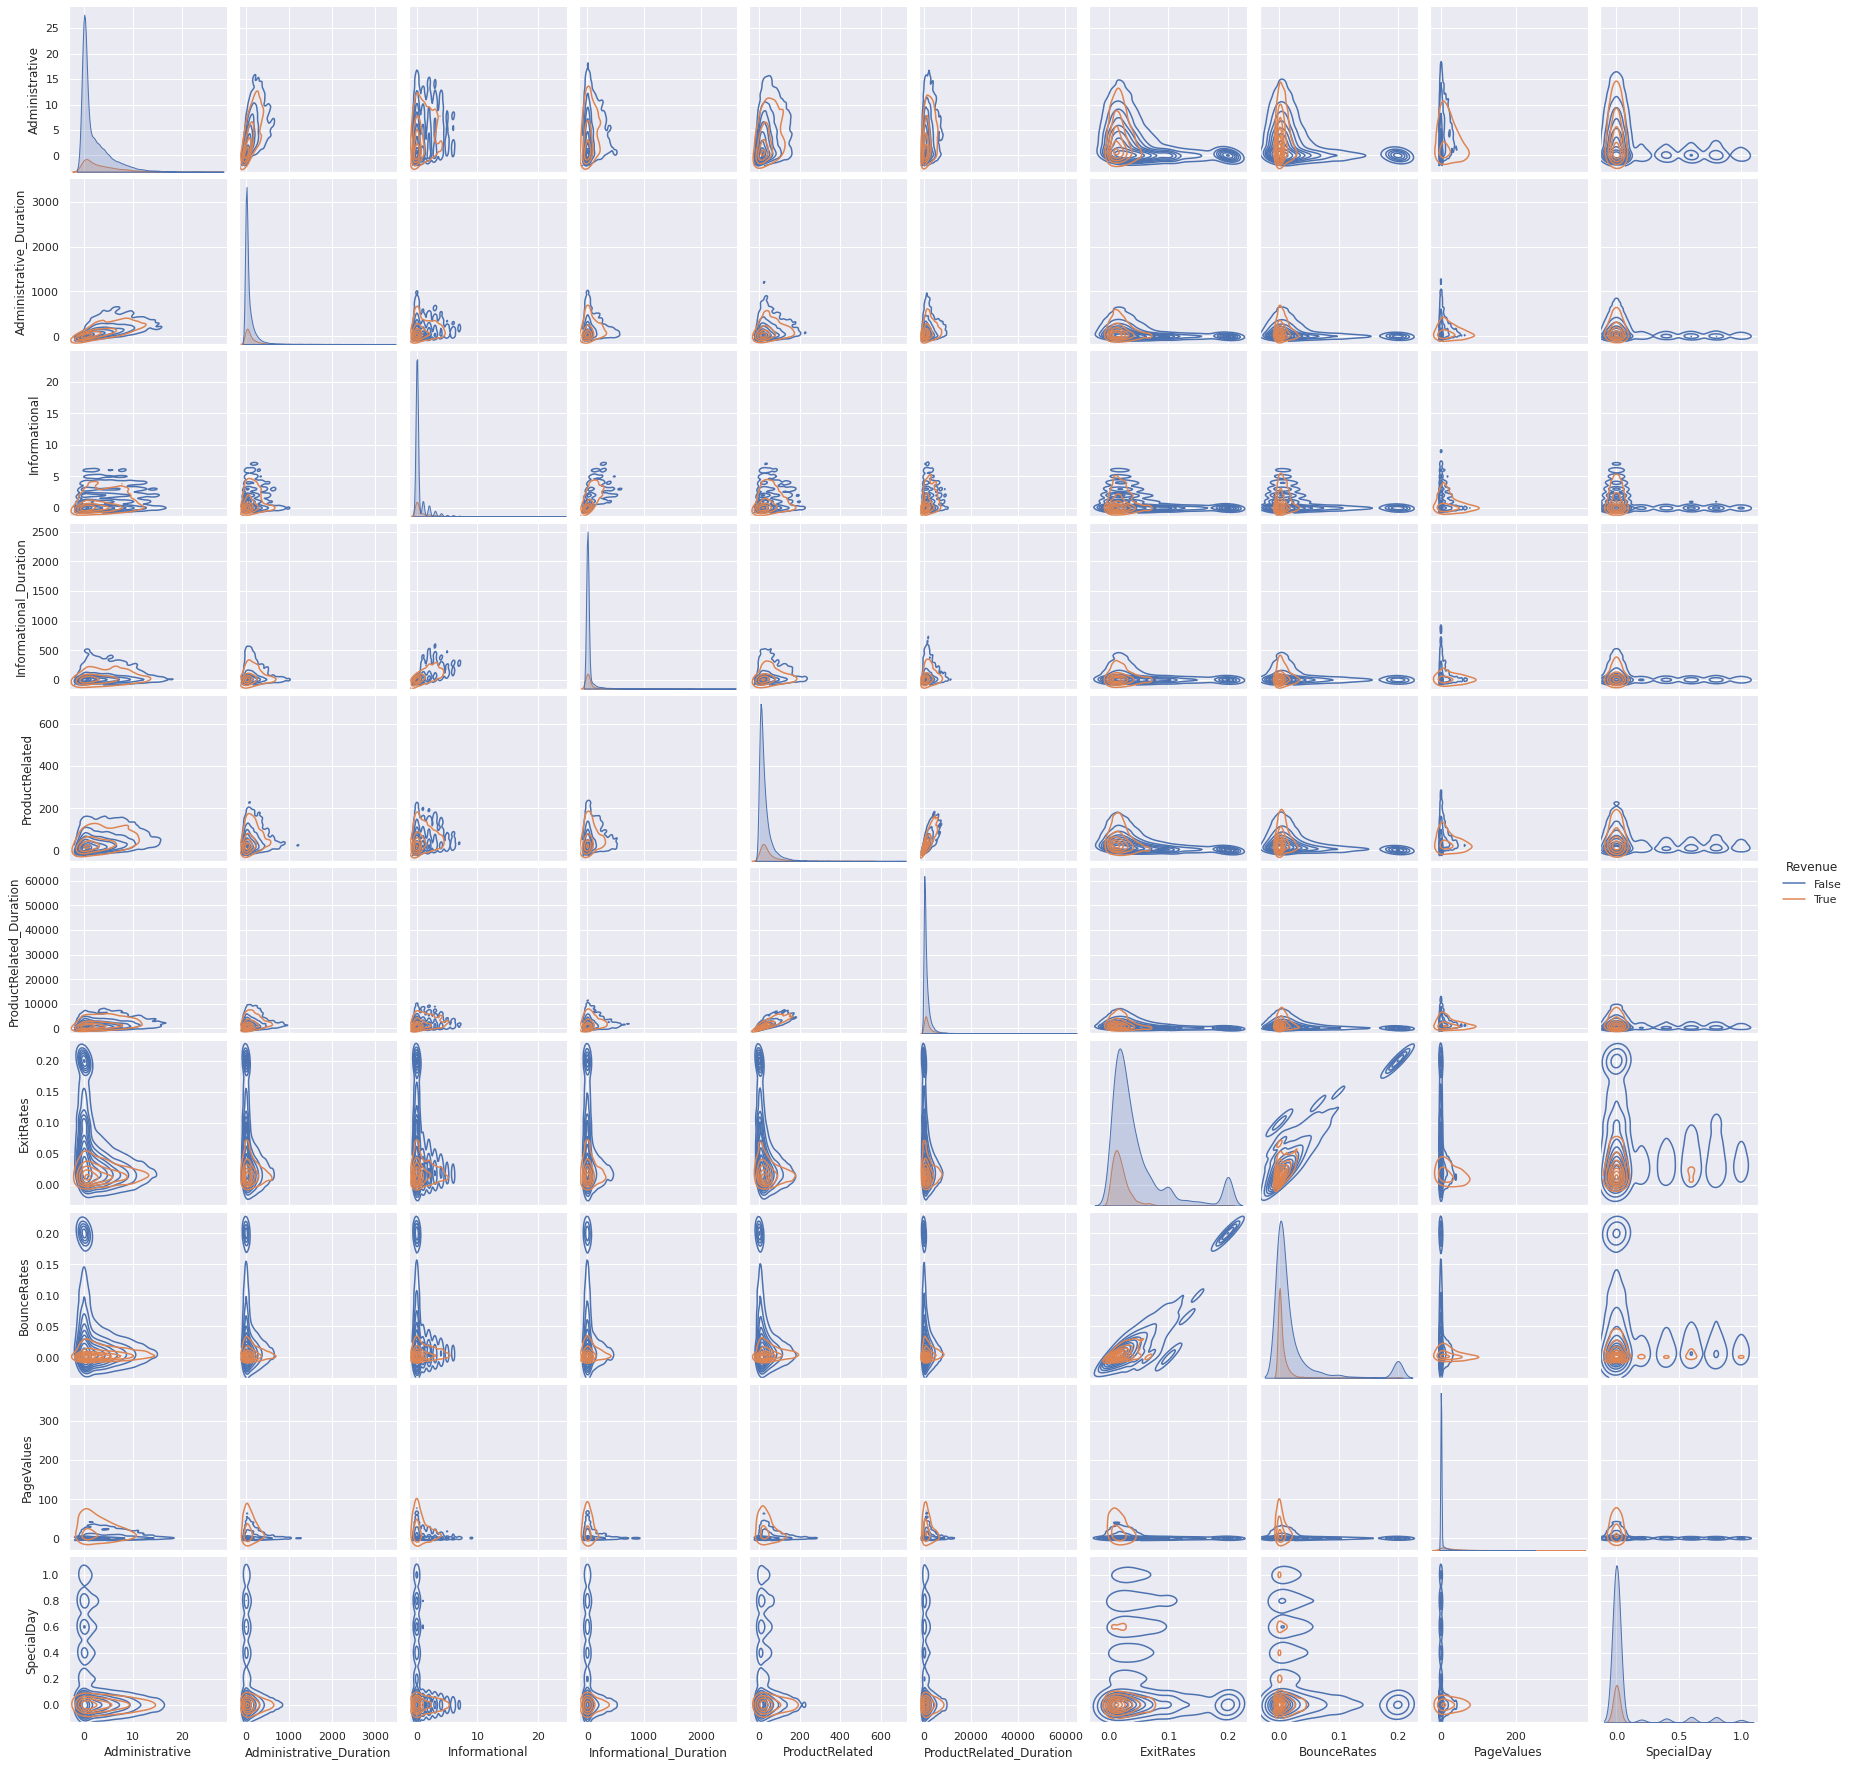

In [26]:
# Generate a seaborn pairplot with kde
sns.pairplot(data=dataframe[[
    "Revenue"
    ,"Administrative"
    ,"Administrative_Duration"
    ,"Informational"
    ,"Informational_Duration"
    ,"ProductRelated"
    ,"ProductRelated_Duration"
    ,"ExitRates"
    ,"BounceRates"
    ,"PageValues"
    ,"SpecialDay"
]],hue="Revenue",kind="kde")
plt.show()

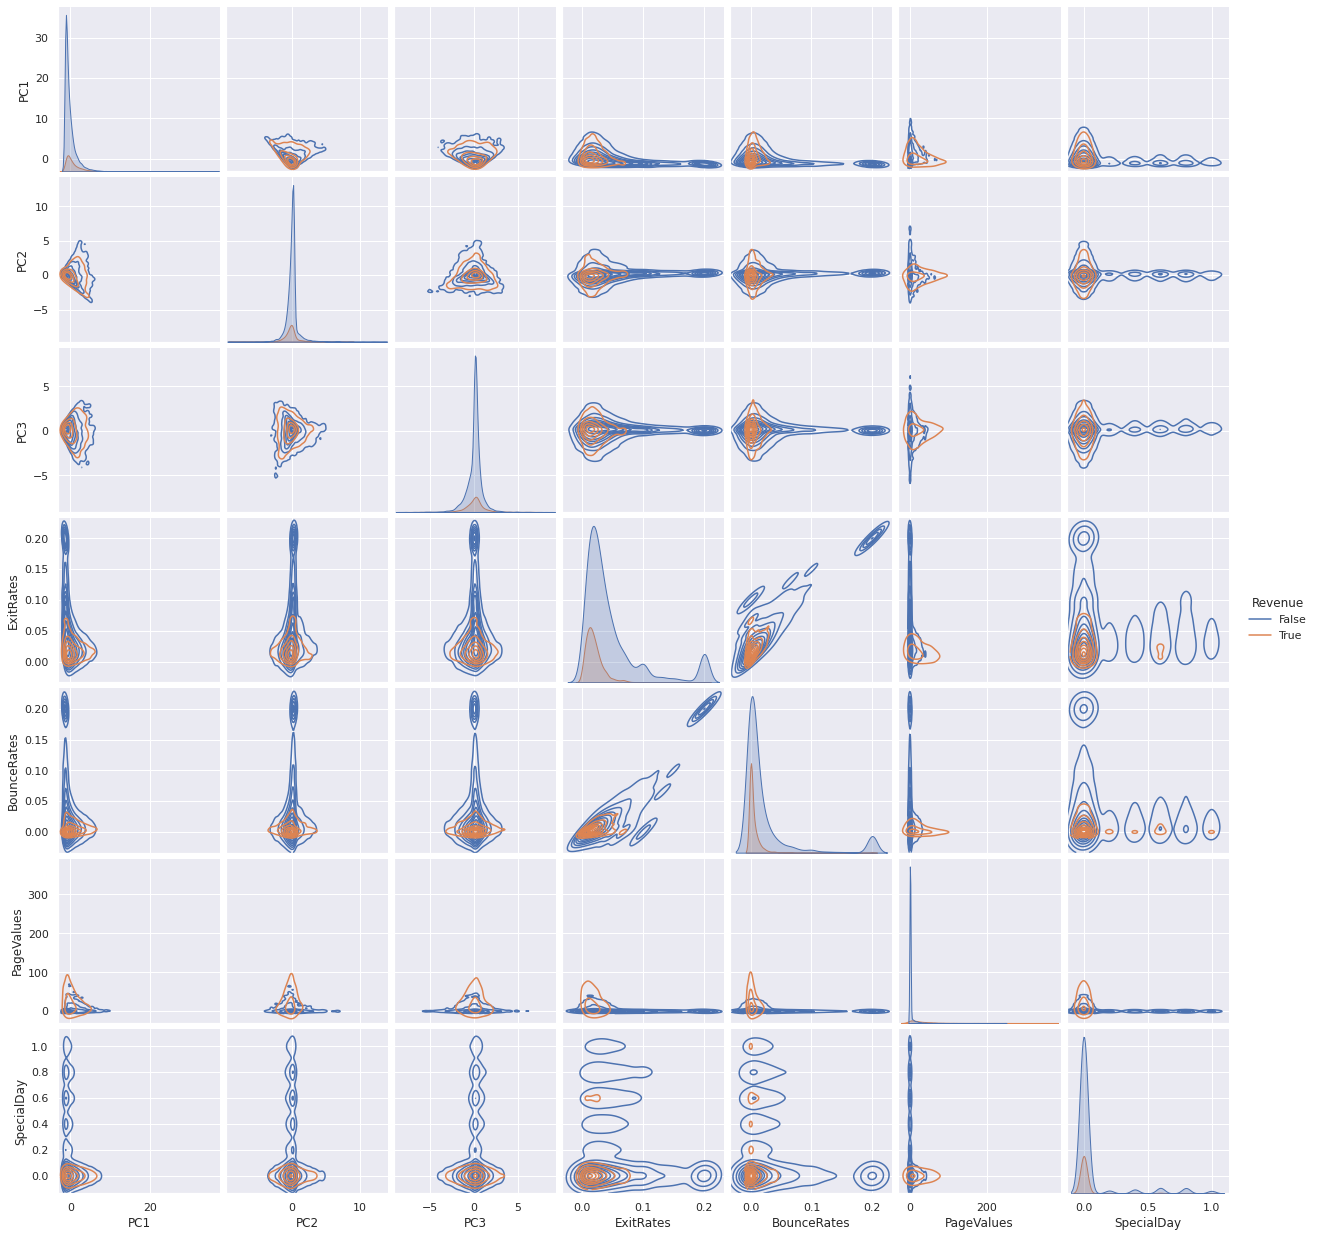

In [32]:
reduced = pd.DataFrame(behavior_reduced)
reduced.columns = ["PC1","PC2","PC3"]
other = dataframe[[
    "Revenue"
    ,"ExitRates"
    ,"BounceRates"
    ,"PageValues"
    ,"SpecialDay"]
]

combined = pd.concat([reduced,other],axis=1)

sns.pairplot(data=combined,hue="Revenue",kind="kde")

In [44]:
dataframe_augmented = pd.concat([dataframe,reduced],axis=1)

For all the numeric variable, there is none that present a patter of having a big impact over the target variable, but the compination with Page Value a different metric could give a understanding of Customers that Buy or not. For categorical variables, we will use different thecniques that let us understand the behavior of the data.

### Data Preprocessing (Setup)

For the data to be use in ML models, we need to have all the variables in a numeric representation and scale in the same scale. For this, It will be use the transformation for the categorical variables and Scaling for numeric, continues value. the data will be separate for months.

In [106]:
target = "Revenue"
numeric_columns = [
    "Administrative"
    ,"Administrative_Duration"
    ,"Informational"
    ,"Informational_Duration"
    ,"ProductRelated"
    ,"ProductRelated_Duration"
    ,"ExitRates"
    ,"BounceRates"
    ,"PageValues"
    ,"SpecialDay"
]

numeric_columns_reduced = [
    "PC1"
    ,"PC2"
    ,"PC3"
    ,"ExitRates"
    ,"BounceRates"
    ,"PageValues"
    ,"SpecialDay"
]

categorical_columns = [
    "VisitorType"
    ,"Region"
    ,"TrafficType"
    ,"OperatingSystems"
    ,"Browser"
    ,"Weekend"
]

In [107]:
# From dataframe, generate Train and Test data. Test data is from Feb - Mar and TRAIN data is from Apr - Dec
months = ["Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
train_data = dataframe_augmented[dataframe_augmented["Month"].isin(months[3:])]
test_data = dataframe_augmented[dataframe_augmented["Month"].isin(months[:3])]

For every categorical variable we will applied a one hot encoder transformation. The Product Related will generate the sparsest matrix given that it has 306 unique values, Every Numeric (Continues variable) will be scaled with different type os techniques. 

In [108]:
steps = []
steps_reduced = []
# Standardize the data
for n in categorical_columns:
    lb = LabelBinarizer()
    steps.append((n,lb))
    steps_reduced.append((n,lb))

# RobustScaler is used to avoid the outliers
for n in numeric_columns:
    scaler = RobustScaler()
    steps.append(([n],scaler))

for n in numeric_columns_reduced:
    scaler = RobustScaler()
    steps_reduced.append(([n],scaler))

# The mapper will applied and return the dataframe
mapper = DataFrameMapper(steps,df_out=True)
mapper_reduced = DataFrameMapper(steps_reduced,df_out=True)

### Data Modeling

In [109]:
# Import Pipeline in order to apply the mapper
from sklearn.pipeline import Pipeline
# Import LogisticRegression, Random Forest and SVM from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Import the Classification Report from sklearn
from sklearn.metrics import classification_report

Metrics to be used for evaluation:

* **F1**: Is a measure of quality of prediction. It is the harmonic mean of precision and recall. High F1 score indicates high quality of prediction.
* **Recall**: is the proportion of actual buyers that the model identify correctly. Its a measure of how many patterns of the target variable are correctly identified by the model.
* **Precision**: is the proportion of correctly identified buyers. Its a measure of how well the model is able to identify buyers. (Confidence)

# Classification Task - Customer recognition (Buying or not)


For the clasification model it will be use a Logistic regression, Random Forest and SVM

#### Iteration #1: Baseline model + Feature Selection

##### Logistic regresion

In [281]:
results = []

In [282]:
def train_model(model,train_data,test_data,target_name,model_name):
    """
    This function trains the model and returns the classification report
    :param model: The model to be trained
    :param train_data: The training data
    :param test_data: The test data
    :param target_name: The name of the target column
    :param model_name: The name of the model
    :return: The classification report
    """
    model.fit(train_data,train_data[target_name])
    predictions = model.predict(test_data)


    classification_report_output = classification_report(test_data[target],predictions,output_dict=True)
    classification_report_output_df = pd.DataFrame(classification_report_output)

    classification_report_output_df["model"] = model_name
    classification_report_output_df.reset_index(inplace=True)
    return model, classification_report_output_df

Scaling Categorical to one hot encoder and scaling Numeric using RobustScaler

In [286]:
logistic = Pipeline([("preprocessing",mapper),("model",LogisticRegression(solver="liblinear"))])
logistic, report = train_model(logistic,train_data,test_data,target,"all_variables_logistic")
results.append(report)
report

,index,False,True,accuracy,macro avg,weighted avg,model
0,precision,0.947395,0.798246,0.939264,0.872820,0.933486,all_variables_logistic
1,recall,0.987869,0.466667,0.939264,0.727268,0.939264,all_variables_logistic
2,f1-score,0.967209,0.588997,0.939264,0.778103,0.931938,all_variables_logistic
3,support,1896.000000,195.000000,0.939264,2091.000000,2091.000000,all_variables_logistic


There are some values that has coeficient around 0 meaning that they are not relevant given a ligistic regresion model

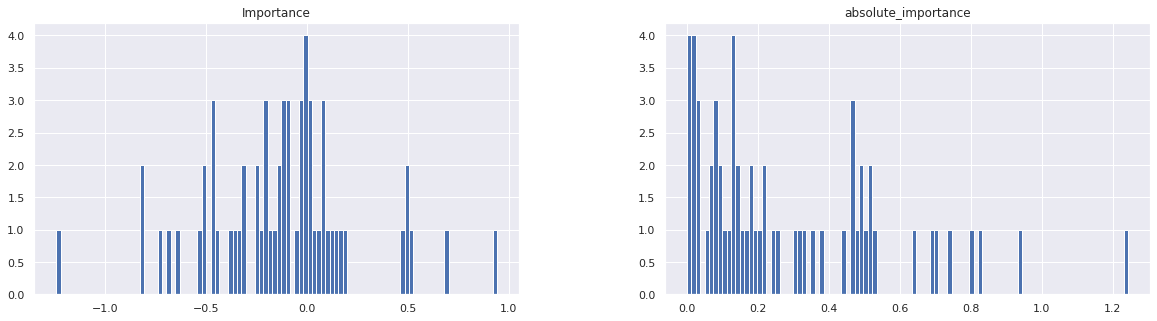

In [216]:
# Extract the feature importances from the model, without the bias term
feature_importances = logistic.named_steps["model"].coef_[0]
feature_names = logistic.named_steps["preprocessing"].transform(train_data).columns.values
# Build a pandas dataframe with the feature importances
feature_importances_df = pd.DataFrame(feature_importances,columns=["Importance"],index=feature_names)
feature_importances_df["absolute_importance"] = feature_importances_df["Importance"].abs()
feature_importances_df.sort_values(by="absolute_importance",ascending=False,inplace=True)
# Histogram of the feature importances
feature_importances_df.hist(bins=100,figsize=(20,5))
plt.show()

In [224]:
feature_importances_df.shape

(61, 2)

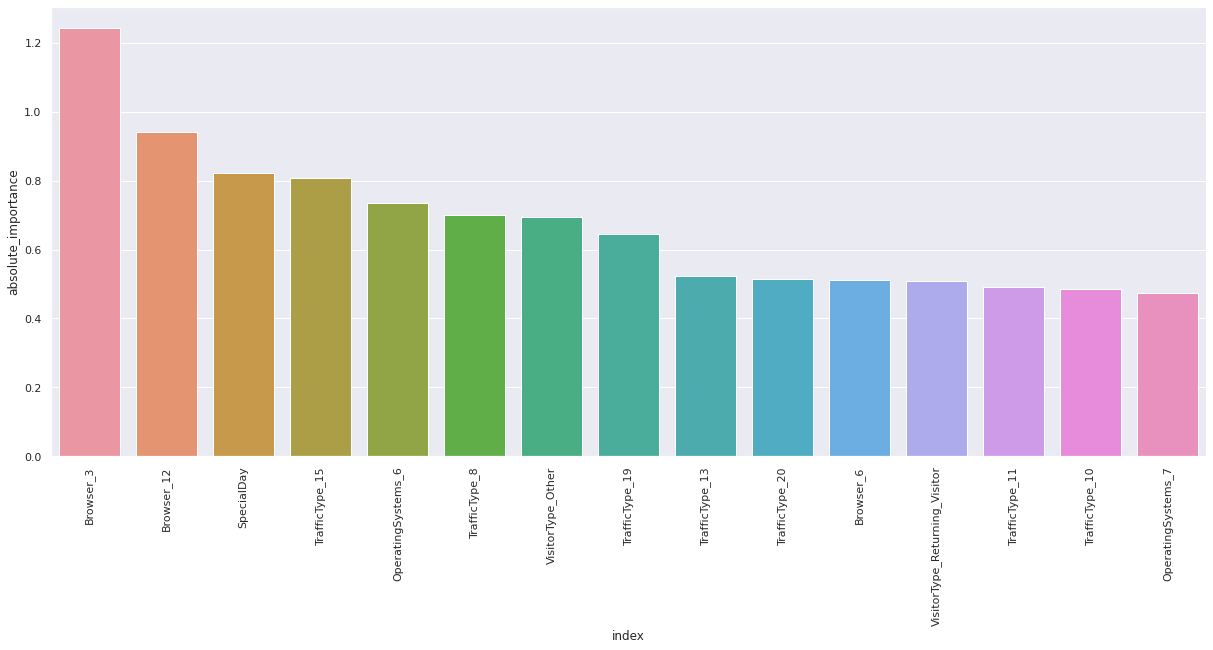

In [225]:
# Horizontal Graph for the feature importances Seaborne plot (Top 50 features)
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.barplot(y="absolute_importance",x="index",data=feature_importances_df.reset_index().head(15))
plt.xticks(rotation=90)
plt.show()


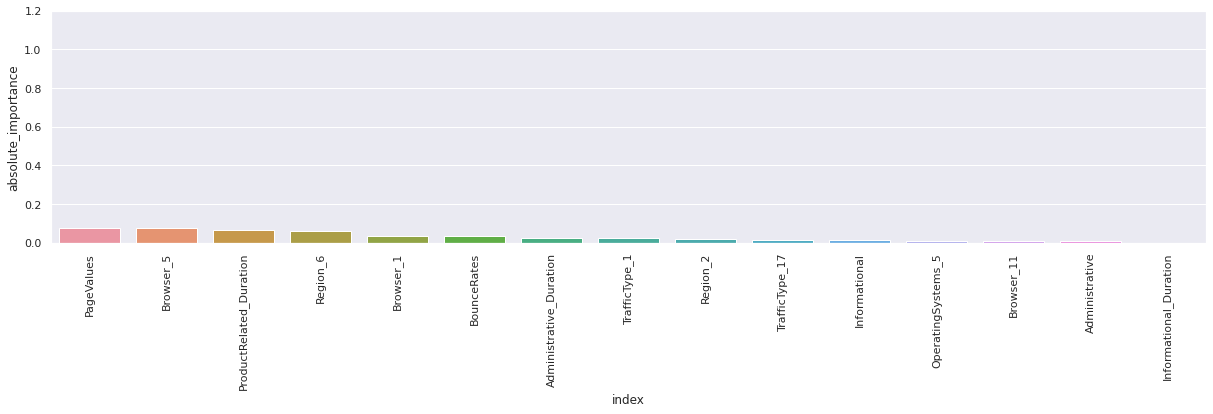

In [226]:
# Horizontal Graph for the feature importances Seaborne plot (Top 50 features)
sns.set(rc={'figure.figsize':(20.7,4.27)})
sns.barplot(y="absolute_importance",x="index",data=feature_importances_df.reset_index().tail(15))
plt.ylim(0,1.2)
plt.xticks(rotation=90)
plt.show()

For a Logistic Regression model the varibles Administrative and Informational Duration could be consider less important given the coeficientent around 0 . we have to take into consideration that this model have a F1 score of 0.59 which is not good.

In [287]:
knn = Pipeline([("preprocessing",mapper_reduced),("model",KNeighborsClassifier(10))])
knn, report = train_model(knn,train_data,test_data,target,"partial_pca_knn")
results.append(report)
report

,index,False,True,accuracy,macro avg,weighted avg,model
0,precision,0.956768,0.750000,0.942133,0.853384,0.937485,partial_pca_knn
1,recall,0.980485,0.569231,0.942133,0.774858,0.942133,partial_pca_knn
2,f1-score,0.968481,0.647230,0.942133,0.807856,0.938523,partial_pca_knn
3,support,1896.000000,195.000000,0.942133,2091.000000,2091.000000,partial_pca_knn


Using a algorithm that use distance base metric and the Principal components of the variables related to the behavior in the section pages (Administrative, Informational and Product Related) we found that the F1 improves to a F1 score of 0.65. 

### Random Forest

For this step it will be used the Random Forest model. The Random Forest model is a meta-learning algorithm that combines many decision trees to build a more accurate model. The Random Forest model is a bagging algorithm that is used to create a forest of decision trees. The trees in the forest are created by randomly selecting features and splitting the data into subsets. The trees in the forest are then trained on the subsets. The trees in the forest are then used to make predictions on the data. compare with the logistic regression, given the feature selection technique, Random Forest can capture different important features.


In [288]:
# Random Forest Classifier
random_forest = Pipeline([("preprocessing",mapper),("random_forest",RandomForestClassifier(n_estimators=500,random_state=0))])
random_forest, report = train_model(random_forest,train_data,test_data,target,"all_variables_random_forest")
results.append(report)
report

,index,False,True,accuracy,macro avg,weighted avg,model
0,precision,0.957797,0.763514,0.944046,0.860655,0.939679,all_variables_random_forest
1,recall,0.981540,0.579487,0.944046,0.780514,0.944046,all_variables_random_forest
2,f1-score,0.969523,0.658892,0.944046,0.814208,0.940555,all_variables_random_forest
3,support,1896.000000,195.000000,0.944046,2091.000000,2091.000000,all_variables_random_forest


In [289]:
# Random Forest Classifier
random_forest_reduced = Pipeline([("preprocessing",mapper_reduced),("random_forest",RandomForestClassifier(n_estimators=500,random_state=0))])
random_forest_reduced,report = train_model(random_forest_reduced,train_data,test_data,target,"partial_pca_random_forest")
results.append(report)
report

,index,False,True,accuracy,macro avg,weighted avg,model
0,precision,0.958290,0.765101,0.944524,0.861696,0.940274,partial_pca_random_forest
1,recall,0.981540,0.584615,0.944524,0.783078,0.944524,partial_pca_random_forest
2,f1-score,0.969776,0.662791,0.944524,0.816283,0.941147,partial_pca_random_forest
3,support,1896.000000,195.000000,0.944524,2091.000000,2091.000000,partial_pca_random_forest


##### Feature Importance Random Forest #####
from sklearn documentation the feature importance is:

    feature_importances_: The impurity-based feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

    Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values). See sklearn.inspection.permutation_importance as an alternative.

It will be applied two metrics to show the importance of the feature

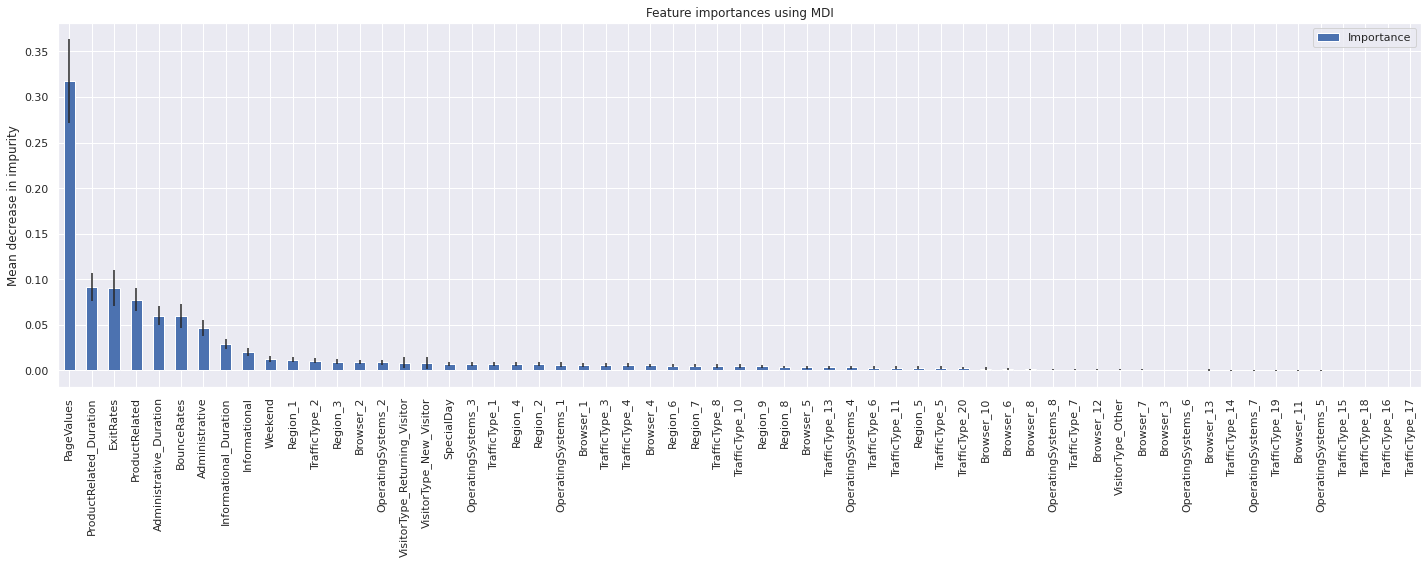

In [290]:
# Feature Importances of the Random Forest Classifier
feature_importances = random_forest.named_steps["random_forest"].feature_importances_
feature_names = random_forest.named_steps["random_forest"].feature_names_in_
std = np.std([tree.feature_importances_ for tree in random_forest.named_steps["random_forest"].estimators_], axis=0)
feature_importances_df = pd.DataFrame({"Importance":feature_importances,"std":std},index=feature_names)
feature_importances_df.sort_values(by="Importance",ascending=False,inplace=True)

fig, ax = plt.subplots()
feature_importances_df.plot.bar(yerr="std", ax=ax,figsize=(20,8))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

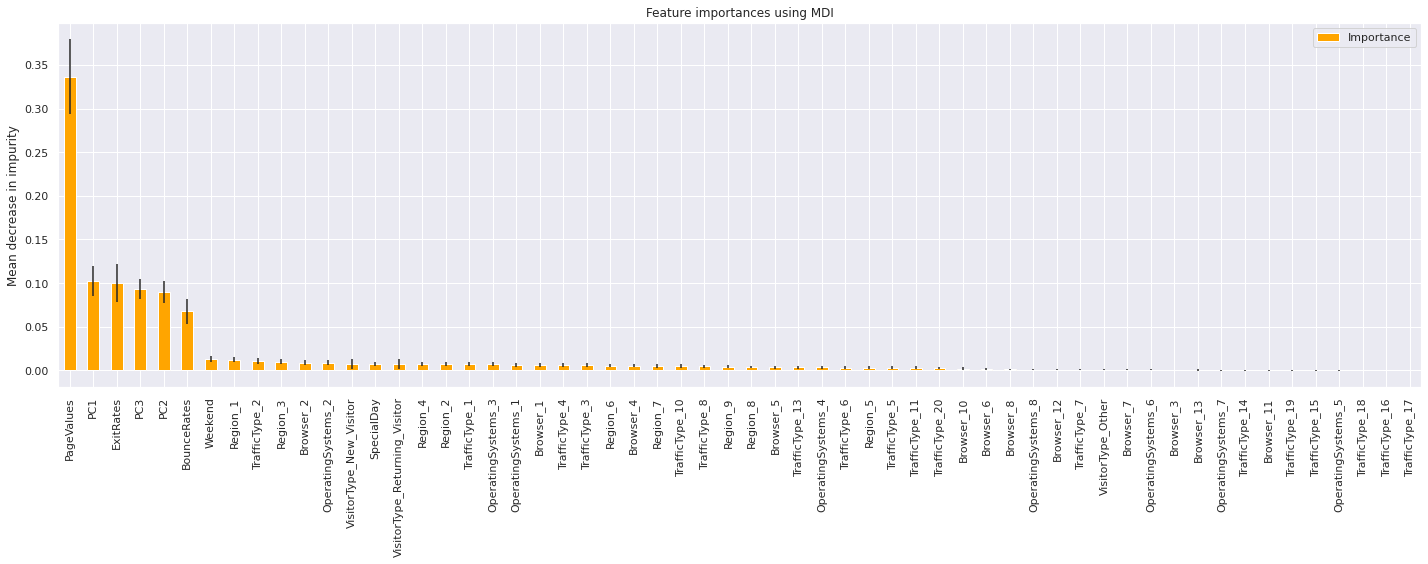

In [295]:
# Feature Importances of the Random Forest Classifier
feature_importances = random_forest_reduced.named_steps["random_forest"].feature_importances_
feature_names = random_forest_reduced.named_steps["random_forest"].feature_names_in_
std = np.std([tree.feature_importances_ for tree in random_forest_reduced.named_steps["random_forest"].estimators_], axis=0)
feature_importances_df = pd.DataFrame({"Importance":feature_importances,"std":std},index=feature_names)
feature_importances_df.sort_values(by="Importance",ascending=False,inplace=True)

fig, ax = plt.subplots()
# bar with color orange
feature_importances_df.plot.bar(yerr="std", ax=ax,figsize=(20,8),color="orange")
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [300]:
pd_result

,index,False,True,accuracy,macro avg,weighted avg,model
2,f1-score,0.967209,0.588997,0.939264,0.778103,0.931938,all_variables_logistic
2,f1-score,0.968481,0.647230,0.942133,0.807856,0.938523,partial_pca_knn
2,f1-score,0.969523,0.658892,0.944046,0.814208,0.940555,all_variables_random_forest
2,f1-score,0.969776,0.662791,0.944524,0.816283,0.941147,partial_pca_random_forest


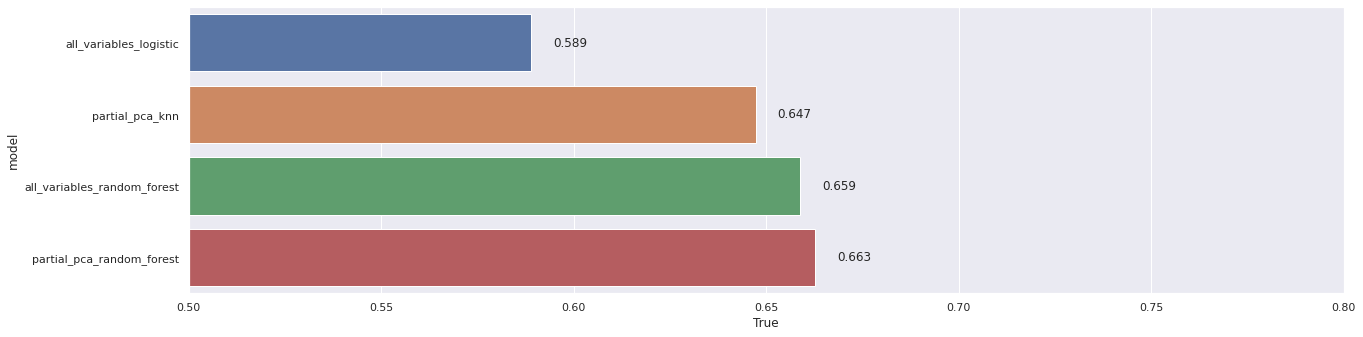

In [309]:
pd_result = pd.concat(results).query("index == 'f1-score'")
# Plot the f1-score for each model
sns.set(rc={'figure.figsize':(20.7,5.27)})
sns.barplot(x="True",y="model",data=pd_result)
# set min of x-axis
plt.xlim(0.5,0.8)
# annotate the bars with the f1-score
for i,j in enumerate(pd_result["True"]):
    plt.text(j+0.01,i,round(j,3),ha="center",va="center")

plt.show()


Random Forest model has the better F1 score than the Logistic Regression model and knn.

#### Iteration #2: Random Forest + Remove less important features

In [311]:
# removing traficf type. operation system and browser from the data
target = "Revenue"
numeric_columns = [
    "Administrative"
    ,"Administrative_Duration"
    ,"Informational"
    ,"Informational_Duration"
    ,"ProductRelated"
    ,"ProductRelated_Duration"
    ,"ExitRates"
    ,"BounceRates"
    ,"PageValues"
    ,"SpecialDay"
]

numeric_columns_reduced = [
    "PC1"
    ,"PC2"
    ,"PC3"
    ,"ExitRates"
    ,"BounceRates"
    ,"PageValues"
    ,"SpecialDay"
]

categorical_columns = [
    "VisitorType"
    ,"Region"
    ,"Weekend"
]

In [312]:
steps = []
steps_reduced = []
# Standardize the data
for n in categorical_columns:
    lb = LabelBinarizer()
    steps.append((n,lb))
    steps_reduced.append((n,lb))

# RobustScaler is used to avoid the outliers
for n in numeric_columns:
    scaler = RobustScaler()
    steps.append(([n],scaler))

for n in numeric_columns_reduced:
    scaler = RobustScaler()
    steps_reduced.append(([n],scaler))

# The mapper will applied and return the dataframe
mapper = DataFrameMapper(steps,df_out=True)
mapper_reduced = DataFrameMapper(steps_reduced,df_out=True)

In [313]:
# Random Forest Classifier
random_forest_reduced = Pipeline([("preprocessing",mapper_reduced),("random_forest",RandomForestClassifier(n_estimators=500,random_state=0))])
random_forest_reduced,report = train_model(random_forest_reduced,train_data,test_data,target,"iteration#2_random_forest")
results.append(report)
report

,index,False,True,accuracy,macro avg,weighted avg,model
0,precision,0.960703,0.757962,0.945481,0.859332,0.941796,iteration#2_random_forest
1,recall,0.979958,0.610256,0.945481,0.795107,0.945481,iteration#2_random_forest
2,f1-score,0.970235,0.676136,0.945481,0.823186,0.942808,iteration#2_random_forest
3,support,1896.000000,195.000000,0.945481,2091.000000,2091.000000,iteration#2_random_forest


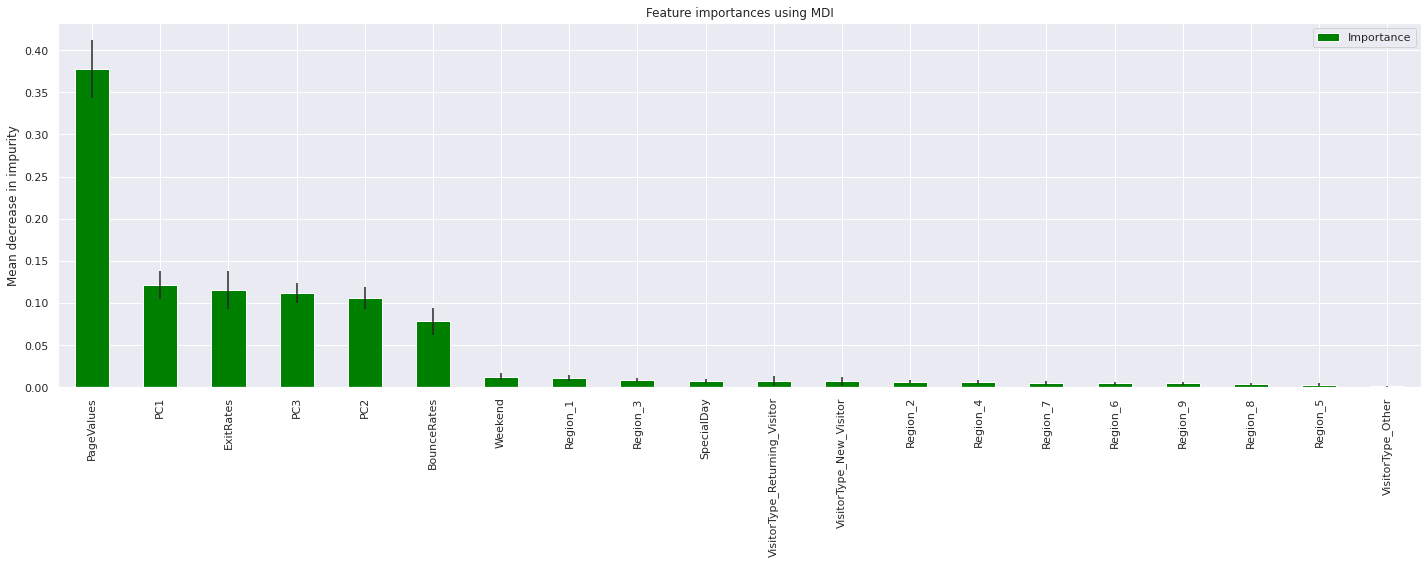

In [314]:
# Feature Importances of the Random Forest Classifier
feature_importances = random_forest_reduced.named_steps["random_forest"].feature_importances_
feature_names = random_forest_reduced.named_steps["random_forest"].feature_names_in_
std = np.std([tree.feature_importances_ for tree in random_forest_reduced.named_steps["random_forest"].estimators_], axis=0)
feature_importances_df = pd.DataFrame({"Importance":feature_importances,"std":std},index=feature_names)
feature_importances_df.sort_values(by="Importance",ascending=False,inplace=True)

fig, ax = plt.subplots()
# bar with color orange
feature_importances_df.plot.bar(yerr="std", ax=ax,figsize=(20,8),color="green")
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Iteration #3: Oversampling + Random Forest + Set of Features

In [315]:
datasets = []
for class_label, df in train_data.groupby("Revenue"):
    if class_label:
        # sample the data with replacement
        df_sample = df.sample(n=int(len(df)*4), replace=True, random_state=0)
        datasets.append(df_sample)
    else:
        datasets.append(df)

In [316]:
train_data_oversample = pd.concat(datasets).sample(frac=1).reset_index(drop=True)

In [317]:
# Random Forest Classifier
random_forest_oversampled = Pipeline([("preprocessing",mapper_reduced),("random_forest",RandomForestClassifier(n_estimators=500,random_state=0))])
random_forest_oversampled,report = train_model(random_forest_oversampled,train_data_oversample,test_data,target,"iteration#3_random_forest")
results.append(report)
report

,index,False,True,accuracy,macro avg,weighted avg,model
0,precision,0.974907,0.678899,0.944046,0.826903,0.947302,iteration#3_random_forest
1,recall,0.963080,0.758974,0.944046,0.861027,0.944046,iteration#3_random_forest
2,f1-score,0.968957,0.716707,0.944046,0.842832,0.945433,iteration#3_random_forest
3,support,1896.000000,195.000000,0.944046,2091.000000,2091.000000,iteration#3_random_forest


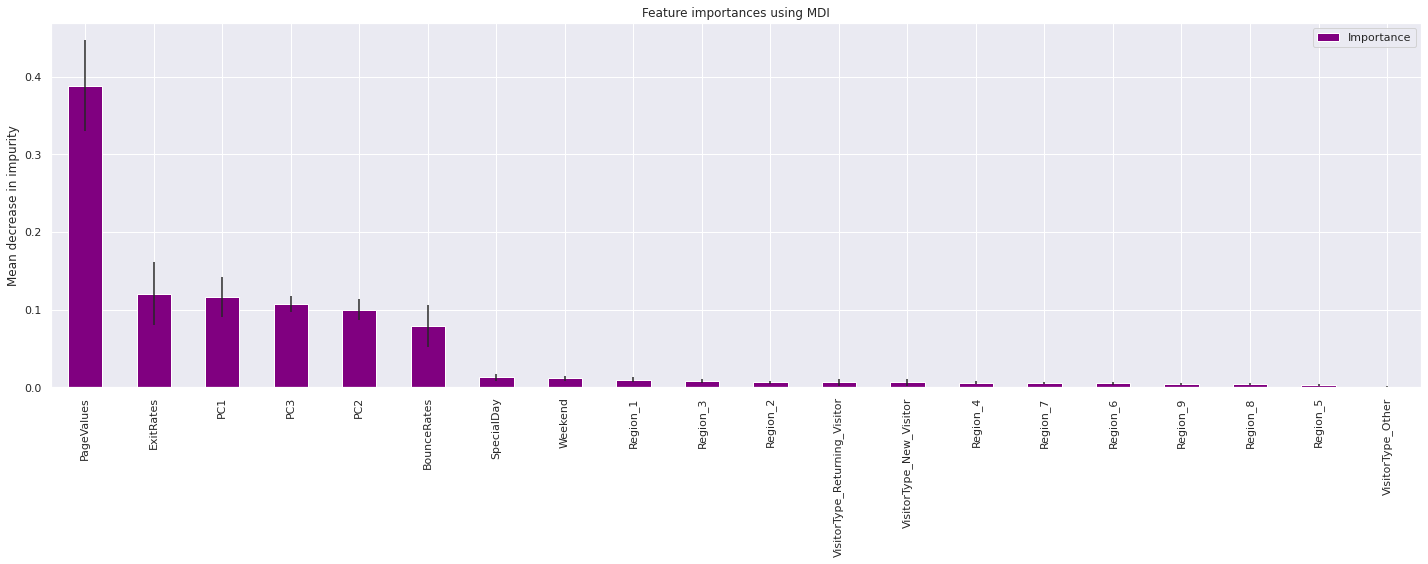

In [318]:
# Feature Importances of the Random Forest Classifier
feature_importances = random_forest_oversampled.named_steps["random_forest"].feature_importances_
feature_names = random_forest_oversampled.named_steps["random_forest"].feature_names_in_
std = np.std([tree.feature_importances_ for tree in random_forest_oversampled.named_steps["random_forest"].estimators_], axis=0)
feature_importances_df = pd.DataFrame({"Importance":feature_importances,"std":std},index=feature_names)
feature_importances_df.sort_values(by="Importance",ascending=False,inplace=True)

fig, ax = plt.subplots()
# bar with color orange
feature_importances_df.plot.bar(yerr="std", ax=ax,figsize=(20,8),color="purple")
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

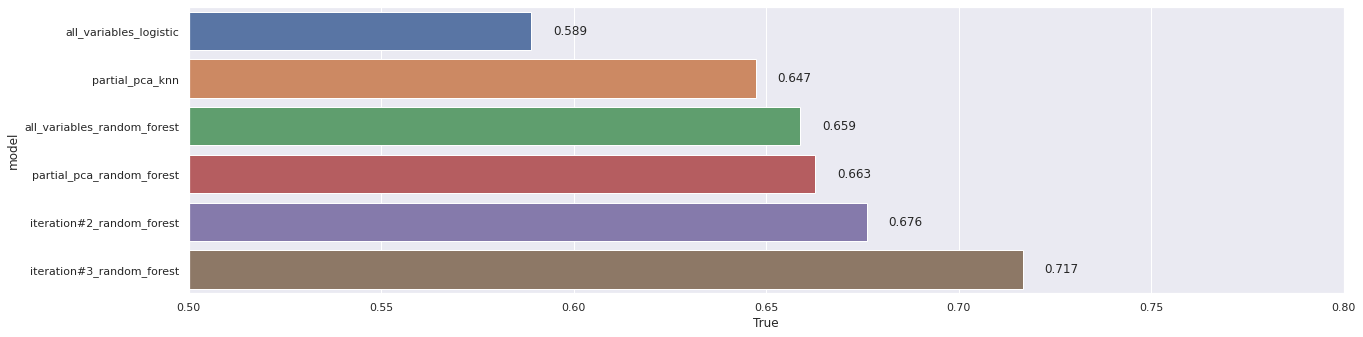

In [319]:
pd_result = pd.concat(results).query("index == 'f1-score'")
# Plot the f1-score for each model
sns.set(rc={'figure.figsize':(20.7,5.27)})
sns.barplot(x="True",y="model",data=pd_result)
# set min of x-axis
plt.xlim(0.5,0.8)
# annotate the bars with the f1-score
for i,j in enumerate(pd_result["True"]):
    plt.text(j+0.01,i,round(j,3),ha="center",va="center")

plt.show()


the final model will have 500 tress

# Cluster Task - Customer Segmentation

In [1]:
import utils

In [9]:
numeric_columns = ["Administrative_Duration","Informational_Duration","ExitRates","BounceRates","PageValues","SpecialDay","ProductRelated_Duration"]


For n_clusters = 2 The average silhouette_score is : 0.5337934013095238
For n_clusters = 3 The average silhouette_score is : 0.5390123359274519
For n_clusters = 4 The average silhouette_score is : 0.528258357791474
For n_clusters = 5 The average silhouette_score is : 0.5436660262180648
For n_clusters = 6 The average silhouette_score is : 0.5398845418864893
For n_clusters = 7 The average silhouette_score is : 0.5066301528459479
For n_clusters = 8 The average silhouette_score is : 0.35764208948507953
For n_clusters = 9 The average silhouette_score is : 0.36009616468750516
For n_clusters = 10 The average silhouette_score is : 0.37048615541342966


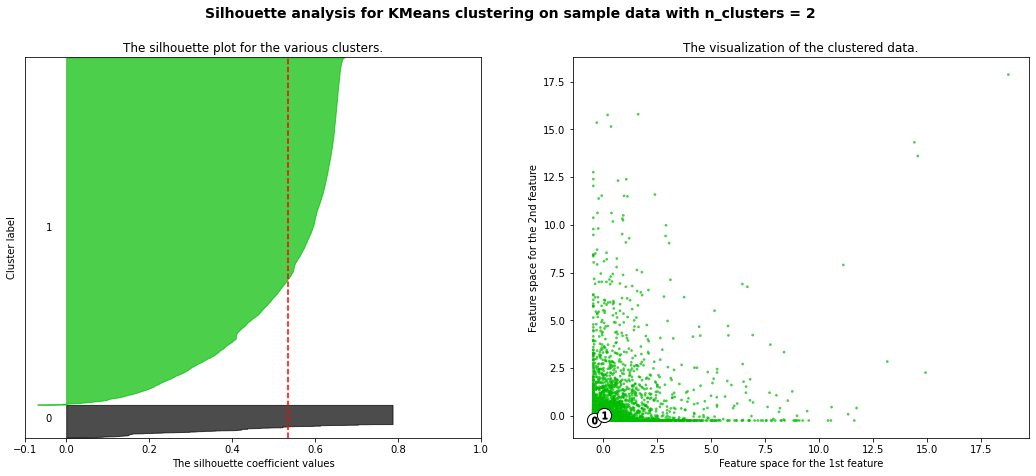

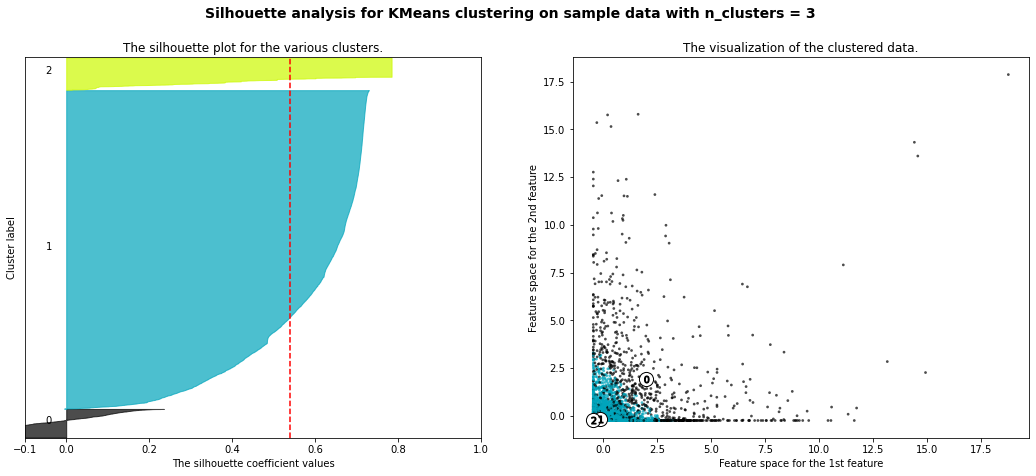

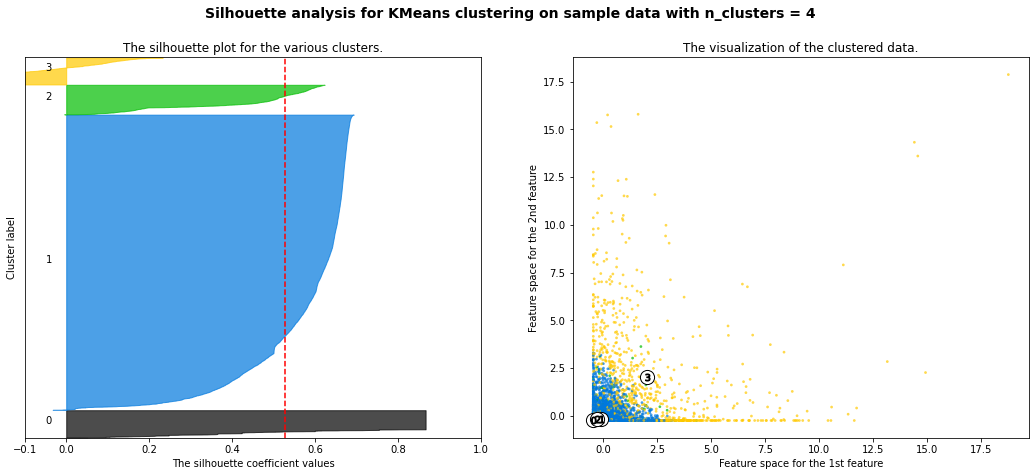

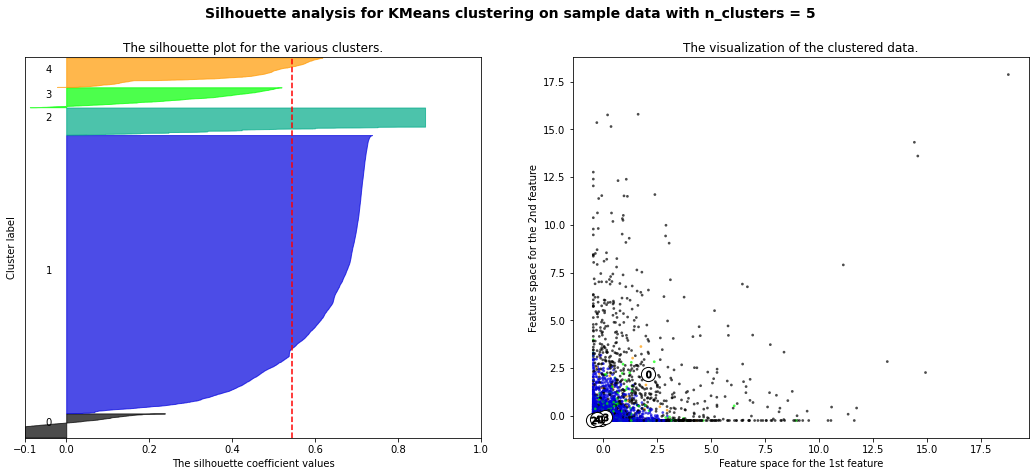

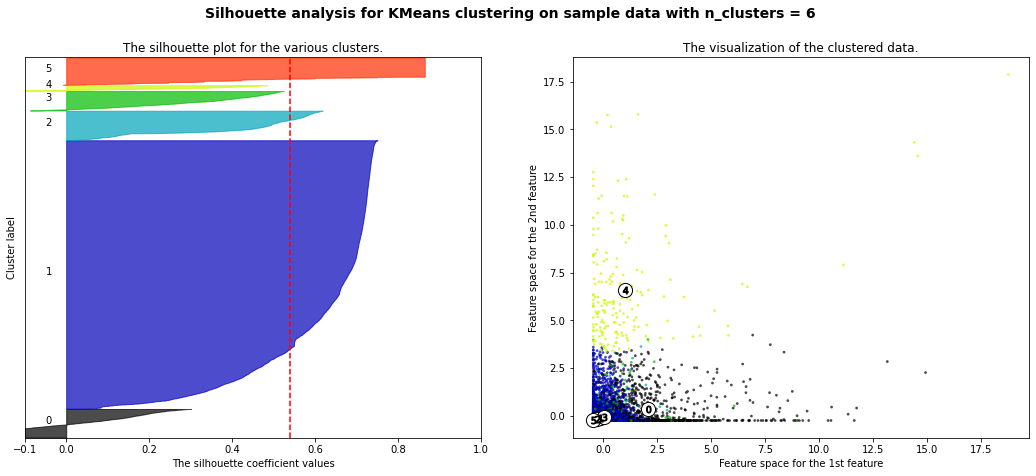

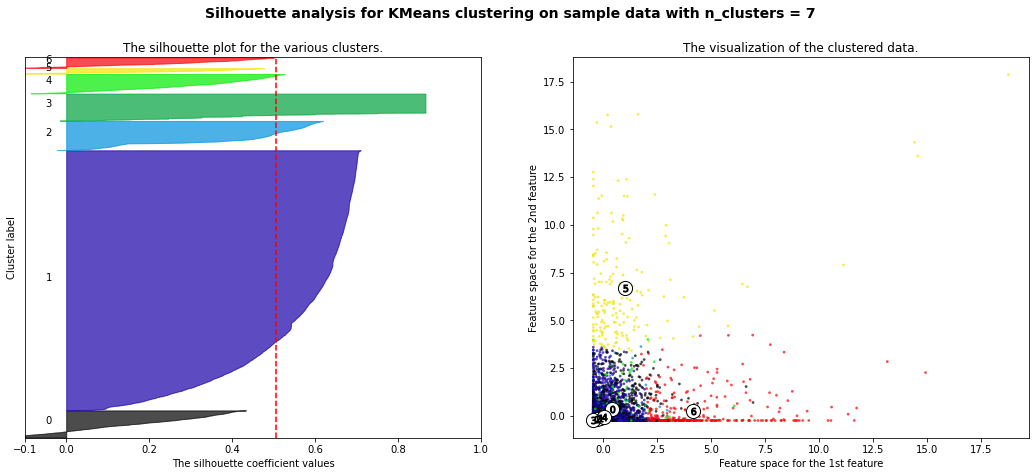

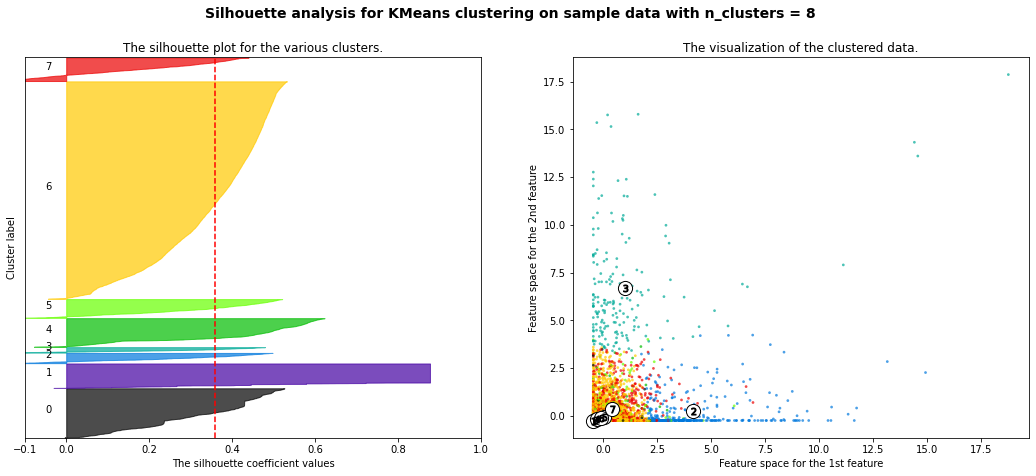

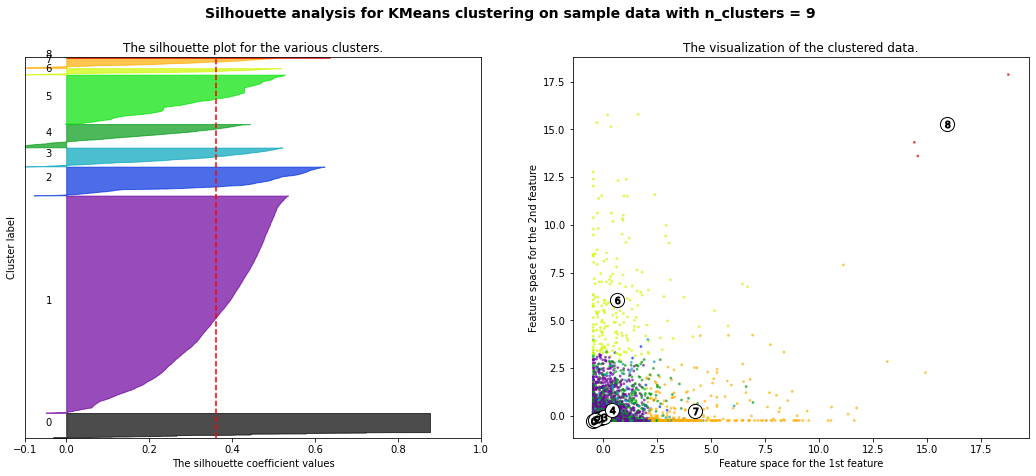

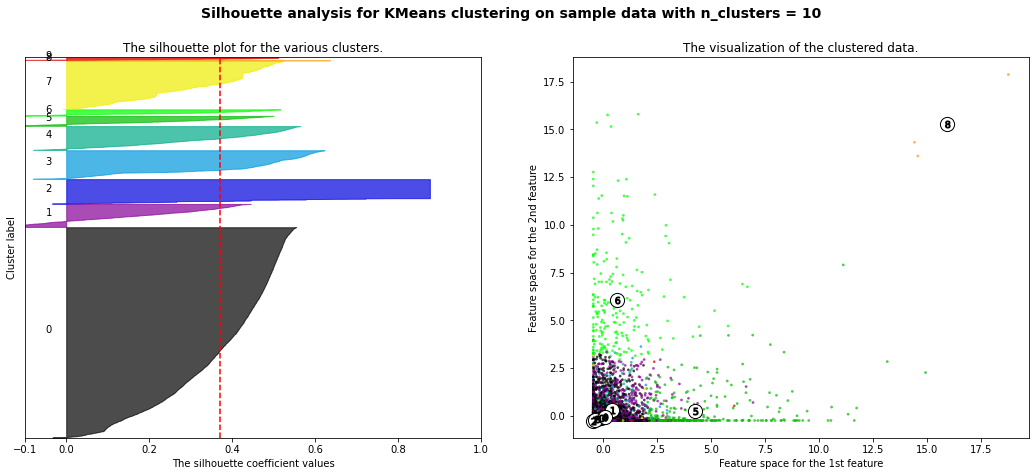

In [14]:
utils.visualize_silhouette(10,StandardScaler().fit_transform( dataframe[numeric_columns]))